# Movie Revenue Prediction

## 1. Pre-processing

In [1]:
# Import necessary libraries
import json
import ast
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score, classification_report, accuracy_score, precision_score, recall_score, f1_score
from xgboost import XGBRegressor, XGBClassifier
from catboost import CatBoostRegressor, Pool
from sklearn.cluster import KMeans
from sklearn.metrics import mean_absolute_error, median_absolute_error, r2_score

In [2]:
# define near zero value
value_nearzero = 0.01
# Model saving flag
save = True

## Helper functions

In [3]:
#  Signed log transformation
def get_signed_log(x):
    if pd.isna(x):
        return np.nan
    elif x >= 0:
        return np.log1p(x)
    else:
        return -np.log1p(abs(x))

In [4]:
def get_first_label(x):
    if isinstance(x, str) and len(x.strip()) > 0:
        try:
            labels = ast.literal_eval(x)
            if isinstance(labels, list) and len(labels) > 0:
                return labels[0]
        except (ValueError, SyntaxError):
            return "Unknown"
    elif isinstance(x, list) and len(x) > 0:
        return x[0]
    return "Unknown"

In [5]:
def get_main_genre(x):
    if isinstance(x, str) and len(x.strip()) > 0:
        try:
            genres = ast.literal_eval(x)
            if isinstance(genres, list) and len(genres) > 0:
                return genres[0]
        except (ValueError, SyntaxError):
            return "Unknown"
    elif isinstance(x, list) and len(x) > 0:
        return x[0]
    return "Unknown"

In [6]:
def get_main_cast(x):
    if isinstance(x, str) and len(x.strip()) > 0:
        try:
            casts = ast.literal_eval(x)
            if isinstance(casts, list) and len(genres) > 0:
                return casts[0]
        except (ValueError, SyntaxError):
            return "Unknown"
    elif isinstance(x, list) and len(x) > 0:
        return x[0]
    return "Unknown"

In [7]:
def inverse_log(x):
    if pd.isna(x):
        return np.nan
    elif x >= 0:
        return np.expm1(x)
    else:
        return -np.expm1(abs(x))

In [8]:
def get_movie_season(month):
    if month in [4, 5, 6, 7]:
        return "Summer_Season"
    elif month in [11, 12]:
        return "Holiday_Season"
    elif month in [8, 9, 10]:
        return "Off_Season"
    else:
        return "Regular"

In [9]:
def get_hit_flop(row):
    if row['revenue_corrected'] > 2*row['budget_corrected']:
        return 1    
    else:
        return 0

In [10]:
def plot_budget_category(movies, category, ymax):
    plt.figure(figsize=(8,4))
    plt.ylim(0,ymax)
    plt.hist(movies[movies['budget_category'] == category]['budget_corrected'], bins=100, edgecolor='k')
    plt.xlabel("Budget (Millions USD)")
    plt.title(f"Bin {category}: Distribution of Movies")
    plt.show()

## Data Loading/merging

In [11]:
# Load CSV files combined (movies + credits) from eda.ipynb

movies_df = pd.read_csv('../data/merged_data.csv')
print(movies_df.shape)

#Load CSV file from tmdb details recived by API call
movies_tmdb_df = pd.read_csv('../data/budget_revenue_tmdb.csv')
print(movies_tmdb_df.shape)

(4803, 28)
(3618, 4)


In [12]:
print("Dataset number of zero budget/revenue samples:", len(movies_df[movies_df['budget'] < value_nearzero]),len(movies_df[movies_df['revenue'] < value_nearzero]))

Dataset number of zero budget/revenue samples: 1037 1427


In [13]:
movies_tmdb_df.columns

Index(['movie_id', 'movie_title', 'budget_tmdb', 'revenue_tmdb'], dtype='object')

In [14]:
print("Tmdb number of zero budget/revenue samples:", len(movies_tmdb_df[movies_tmdb_df['budget_tmdb'] < value_nearzero]),len(movies_tmdb_df[movies_tmdb_df['revenue_tmdb'] < value_nearzero]))

Tmdb number of zero budget/revenue samples: 0 0


In [15]:
nan_df = movies_tmdb_df.isna().sum()
print("TMDB Features with NaN:\n", nan_df)

TMDB Features with NaN:
 movie_id        0
movie_title     0
budget_tmdb     0
revenue_tmdb    0
dtype: int64


In [16]:
# Print colums with nan
nan_df = movies_df.isna().sum()
nan_nonzero = nan_df[nan_df > 0]
print("Dataset Features with NaN:", nan_nonzero.index.tolist())

Dataset Features with NaN: ['homepage', 'overview', 'release_date', 'runtime', 'tagline', 'release_year', 'release_month']


In [17]:
movies_full_df = movies_df.merge(movies_tmdb_df[['movie_id', 'budget_tmdb', 'revenue_tmdb']],
                                 on='movie_id', how='inner')

In [18]:
movies_full_df.shape

(3618, 30)

## Data cleaning/transformation

In [19]:
def choose_budget(row):
    budget_tmdb = row['budget_tmdb']
    budget = row['budget']    

    if budget_tmdb > value_nearzero and (not pd.isna(budget_tmdb)):
        if (budget < value_nearzero):
            return budget_tmdb             
        elif (budget_tmdb > 2*budget):
            return budget_tmdb        
    return budget

In [20]:
def choose_revenue(row):
    revenue_tmdb = row['revenue_tmdb']
    revenue = row['revenue']   

    if revenue_tmdb > value_nearzero and (not pd.isna(revenue_tmdb)):
        if (revenue < value_nearzero):
            return revenue_tmdb            
        elif (revenue_tmdb > 2*revenue):
            return revenue_tmdb       
    return revenue

In [21]:
print(movies_full_df.shape)
print(len(movies_full_df[movies_full_df['budget_tmdb'] < value_nearzero]))
print(len(movies_full_df[movies_full_df['budget_tmdb'] < value_nearzero]))

print(len(movies_full_df[movies_full_df['budget'] < value_nearzero]))
print(len(movies_full_df[movies_full_df['budget'] < value_nearzero]))

(3618, 30)
0
0
375
375


In [22]:
# Select the tmdb value in case dataset value is near zero or differ more than twice
movies_full_df['budget'] = movies_full_df.apply(choose_budget, axis=1)
movies_full_df['revenue'] = movies_full_df.apply(choose_revenue, axis=1)

In [23]:
print(movies_full_df.shape)
print(len(movies_full_df[movies_full_df['budget'] < value_nearzero]))
print(len(movies_full_df[movies_full_df['revenue'] < value_nearzero]))

(3618, 30)
0
0


In [24]:
# Convert rating type to int
movies_full_df['vote_average'] = movies_full_df['vote_average'].apply(int)

In [25]:
# Convert string to list for genre_labels
movies_full_df["genre_labels"] = movies_full_df["genre_labels"].apply(
    lambda x: ast.literal_eval(x) if isinstance(x, str) else x
)

In [26]:
# load CPI dataset to correct budget/revenue for inflation
cpi = pd.read_csv("../data/flat-ui__data-Wed Jul 02 2025.csv")
cpi['Date'] = pd.to_datetime(cpi['Date'])

In [27]:
cpi = cpi.rename(columns={'Index': 'CPI'})
cpi.drop(columns=['Inflation'], inplace=True)
print(cpi.head())

        Date      CPI
0 2023-12-01  306.746
1 2023-11-01  307.051
2 2023-10-01  307.671
3 2023-09-01  307.789
4 2023-08-01  307.026


In [28]:
movies_full_df.columns

Index(['budget', 'genres', 'homepage', 'movie_id', 'keywords',
       'original_language', 'original_title', 'overview', 'popularity',
       'production_companies', 'production_countries', 'release_date',
       'revenue', 'runtime', 'spoken_languages', 'status', 'tagline',
       'movie_title', 'vote_average', 'vote_count', 'title', 'cast', 'crew',
       'release_year', 'release_month', 'genre_labels', 'top_cast',
       'production_companies_list', 'budget_tmdb', 'revenue_tmdb'],
      dtype='object')

In [29]:
# drop colums not required for revenue prediction
drop_columns = ['genres', 'homepage', 'movie_id', 'keywords',
                'original_title', 'overview','production_companies',
                'production_countries', 'spoken_languages','tagline', 'movie_title',
               'cast', 'crew','top_cast','production_companies_list',
               'budget_tmdb', 'revenue_tmdb']
movies = movies_full_df.drop(columns=drop_columns)

In [30]:
# Keep only rows where status is 'Released'
movies = movies[(movies["status"] == "Released")].reset_index(drop=True)

In [31]:
movies.shape

(3617, 13)

In [32]:
# Inflation correction
# Get current CPI index
cpi_May_2025 = 320.580 # current value from https://fred.stlouisfed.org/series/CPIAUCSL
million = 1e6

In [33]:
movies['release_date'] = pd.to_datetime(movies['release_date'])
# Round to the first day of the release month to match with CPI date
movies['cpi_date'] = movies['release_date'].values.astype('datetime64[M]')

In [34]:
# Merge CPI to movies
movies = movies.merge(cpi, left_on='cpi_date',  right_on='Date', how='left')
movies.drop(columns=['Date'], inplace=True)

print(movies.shape)

(3617, 15)


In [35]:
# Get the correction multiplier for each movie
movies["cpi_multiplier"] = cpi_May_2025 / movies["CPI"]

# Correct budget and revenue
movies["budget_corrected"] = movies["budget"] * movies["cpi_multiplier"]/million
movies["revenue_corrected"] = movies["revenue"] * movies["cpi_multiplier"]/million

In [36]:
len(movies["revenue_corrected"])

3617

In [37]:
movies.head()

,budget,original_language,popularity,release_date,revenue,runtime,status,vote_average,vote_count,title,release_year,release_month,genre_labels,cpi_date,CPI,cpi_multiplier,budget_corrected,revenue_corrected
0,237000000.0,en,150.437577,2009-12-10,2.787965e+09,162.0,Released,7,11800,Avatar,2009.0,12.0,"[Action, Adventure, Fantasy, Science Fiction]",2009-12-01,215.949,1.484517,351.830571,4138.782062
1,300000000.0,en,139.082615,2007-05-19,9.610000e+08,169.0,Released,6,4500,Pirates of the Caribbean: At World's End,2007.0,5.0,"[Adventure, Fantasy, Action]",2007-05-01,207.949,1.541628,462.488399,1481.504504
2,245000000.0,en,107.376788,2015-10-26,8.806746e+08,148.0,Released,6,4466,Spectre,2015.0,10.0,"[Action, Adventure, Crime]",2015-10-01,237.838,1.347892,330.233604,1187.054492
3,250000000.0,en,112.312950,2012-07-16,1.084939e+09,165.0,Released,7,9106,The Dark Knight Rises,2012.0,7.0,"[Action, Crime, Drama, Thriller]",2012-07-01,229.104,1.399277,349.819296,1518.130527
4,260000000.0,en,43.926995,2012-03-07,2.841391e+08,132.0,Released,6,2124,John Carter,2012.0,3.0,"[Action, Adventure, Science Fiction]",2012-03-01,229.392,1.397520,363.355304,397.090189


In [38]:
# Cap the upper bound to the 98th percentile value to prevent high valued extreme outliers 
upper = movies["revenue_corrected"].quantile(0.98)
print("upper:", upper)
movies["revenue_corrected"] = np.where(
    (movies["revenue_corrected"] > upper) & (movies["revenue_corrected"] > 2 * movies["budget_corrected"]),
    upper,
    movies["revenue_corrected"]
)

upper: 1162.0999723262516


In [39]:
print(movies.columns)
# Print colums with nan
nan_df = movies.isna().sum()
nan_nonzero = nan_df[nan_df > 0]
print("Features with NaN:", nan_nonzero.index.tolist())

Index(['budget', 'original_language', 'popularity', 'release_date', 'revenue',
       'runtime', 'status', 'vote_average', 'vote_count', 'title',
       'release_year', 'release_month', 'genre_labels', 'cpi_date', 'CPI',
       'cpi_multiplier', 'budget_corrected', 'revenue_corrected'],
      dtype='object')
Features with NaN: []


In [40]:
movies.head()

,budget,original_language,popularity,release_date,revenue,runtime,status,vote_average,vote_count,title,release_year,release_month,genre_labels,cpi_date,CPI,cpi_multiplier,budget_corrected,revenue_corrected
0,237000000.0,en,150.437577,2009-12-10,2.787965e+09,162.0,Released,7,11800,Avatar,2009.0,12.0,"[Action, Adventure, Fantasy, Science Fiction]",2009-12-01,215.949,1.484517,351.830571,1162.099972
1,300000000.0,en,139.082615,2007-05-19,9.610000e+08,169.0,Released,6,4500,Pirates of the Caribbean: At World's End,2007.0,5.0,"[Adventure, Fantasy, Action]",2007-05-01,207.949,1.541628,462.488399,1162.099972
2,245000000.0,en,107.376788,2015-10-26,8.806746e+08,148.0,Released,6,4466,Spectre,2015.0,10.0,"[Action, Adventure, Crime]",2015-10-01,237.838,1.347892,330.233604,1162.099972
3,250000000.0,en,112.312950,2012-07-16,1.084939e+09,165.0,Released,7,9106,The Dark Knight Rises,2012.0,7.0,"[Action, Crime, Drama, Thriller]",2012-07-01,229.104,1.399277,349.819296,1162.099972
4,260000000.0,en,43.926995,2012-03-07,2.841391e+08,132.0,Released,6,2124,John Carter,2012.0,3.0,"[Action, Adventure, Science Fiction]",2012-03-01,229.392,1.397520,363.355304,397.090189


# 2. Feature Engineering

In [41]:
movies["hit_flop"] = movies.apply(get_hit_flop, axis=1)
print(movies["hit_flop"].value_counts())


1    1820
0    1797
Name: hit_flop, dtype: int64


In [42]:
# Convert highly skewed feature to log scale
movies["log_budget"] = np.log1p(movies["budget_corrected"]) 
movies["log_revenue"] = np.log1p(movies["revenue_corrected"])

#### Budget binning

In [43]:
# Apply kmean clustering to get the budget bin 
# use the log scale for binning
budgets = movies['log_budget'].values

# Set number of bins
N_CLUSTER = 10

# Compute quantile edges
quantiles = np.linspace(0, 1, N_CLUSTER + 1)
bin_edges = np.quantile(budgets, quantiles)

# Compute bin midpoints
initial_centers = (bin_edges[:-1] + bin_edges[1:]) / 2

# Reshape for KMeans
initial_centers = initial_centers.reshape(-1, 1)

# Prepare budgets for KMeans
budgets_reshaped = budgets.reshape(-1, 1)

# Run KMeans
kmeans = KMeans(
    n_clusters=N_CLUSTER,
    init=initial_centers,
    n_init=1,
    random_state=42
)

# Fit model
movies['budget_category'] = kmeans.fit_predict(budgets_reshaped)

# Get cluster centers
centers = kmeans.cluster_centers_.flatten()

# Sort centers so lowest center is bin 0
sorted_indices = np.argsort(centers)
labels = [f"C{i}" for i in range(len(sorted_indices))]

# Check length
if len(labels) != len(centers):
    raise ValueError("Number of labels must match number of clusters!")
    
bin_label_map = {bin_number: labels[rank] 
                 for rank, bin_number in enumerate(sorted_indices)}

bin_center_map = {labels[rank]: centers[bin_number]
                 for rank, bin_number in enumerate(sorted_indices)}

# Map numeric bins to names
movies['budget_bin_label'] = movies['budget_category'].map(bin_label_map)

print("Cluster centers (log scaled):", centers)

Cluster centers (log scaled): [0.62673106 1.75753943 2.51396784 3.06803506 3.50945681 3.92503013
 4.30381654 4.6560899  5.04057064 5.52715542]


In [44]:
centers

array([0.62673106, 1.75753943, 2.51396784, 3.06803506, 3.50945681,
       3.92503013, 4.30381654, 4.6560899 , 5.04057064, 5.52715542])

In [45]:
movies['budget_category'].unique()

array([9, 8, 3, 6, 7, 2, 5, 4, 1, 0])

In [46]:
#print(movies.describe())

In [47]:
movies['title_len'] = movies['title'].apply( lambda x: len(x) if pd.notna(x) else 0)

In [48]:
# Get main genre label
movies["main_genre"] = movies["genre_labels"].apply(lambda s: s[0] if isinstance(s, list) and len(s) > 0 else "Unknown")

# label encode main genre
le = LabelEncoder()
movies["main_genre_label"] = le.fit_transform(movies["main_genre"])

In [49]:
movies["main_genre"].value_counts()

Drama              840
Comedy             801
Action             644
Adventure          303
Horror             212
Crime              147
Thriller           125
Animation          112
Fantasy             97
Science Fiction     75
Romance             72
Family              45
Documentary         29
Music               27
Mystery             27
War                 21
History             19
Western             17
Unknown              2
Foreign              2
Name: main_genre, dtype: int64

In [50]:
movies["movie_season"] = movies["release_month"].apply(get_movie_season)
print(movies["movie_season"].value_counts())

Summer_Season     1117
Off_Season        1092
Regular            774
Holiday_Season     634
Name: movie_season, dtype: int64


In [51]:
# impute runtime NaN with median runtime grouped on the original language
median_runtime_by_lang = movies.groupby('original_language')['runtime'].median()
print("en runtime:", median_runtime_by_lang['en'])
print("hi runtime:", median_runtime_by_lang['hi'])
# Impute missing runtime
def impute_runtime(row):
    if pd.isna(row['runtime']) or row['runtime']<value_nearzero:
        return median_runtime_by_lang[row['original_language']]
    else:
        return row['runtime']
movies['runtime'] = movies.apply(impute_runtime, axis=1)

en runtime: 105.0
hi runtime: 157.0


In [52]:
le_season = LabelEncoder()
movies["season_encoded"] = le_season.fit_transform(movies["movie_season"])

In [53]:
movies.head()

,budget,original_language,popularity,release_date,revenue,runtime,status,vote_average,vote_count,title,...,hit_flop,log_budget,log_revenue,budget_category,budget_bin_label,title_len,main_genre,main_genre_label,movie_season,season_encoded
0,237000000.0,en,150.437577,2009-12-10,2.787965e+09,162.0,Released,7,11800,Avatar,...,1,5.865988,7.058844,9,C9,6,Action,0,Holiday_Season,0
1,300000000.0,en,139.082615,2007-05-19,9.610000e+08,169.0,Released,6,4500,Pirates of the Caribbean: At World's End,...,1,6.138781,7.058844,9,C9,40,Adventure,1,Summer_Season,3
2,245000000.0,en,107.376788,2015-10-26,8.806746e+08,148.0,Released,6,4466,Spectre,...,1,5.802824,7.058844,9,C9,7,Action,0,Off_Season,1
3,250000000.0,en,112.312950,2012-07-16,1.084939e+09,165.0,Released,7,9106,The Dark Knight Rises,...,1,5.860271,7.058844,9,C9,21,Action,0,Summer_Season,3
4,260000000.0,en,43.926995,2012-03-07,2.841391e+08,132.0,Released,6,2124,John Carter,...,0,5.898130,5.986679,9,C9,11,Action,0,Regular,2


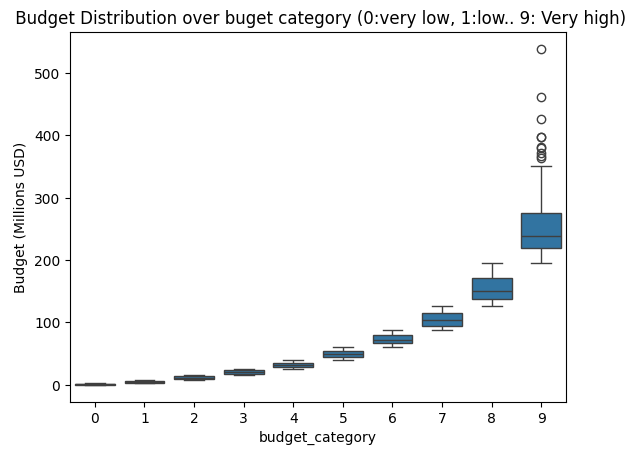

In [54]:
sns.boxplot(x='budget_category', y='budget_corrected', data=movies)
plt.ylabel("Budget (Millions USD)")
plt.title(f" Budget Distribution over buget category (0:very low, 1:low.. 9: Very high)")
plt.show()

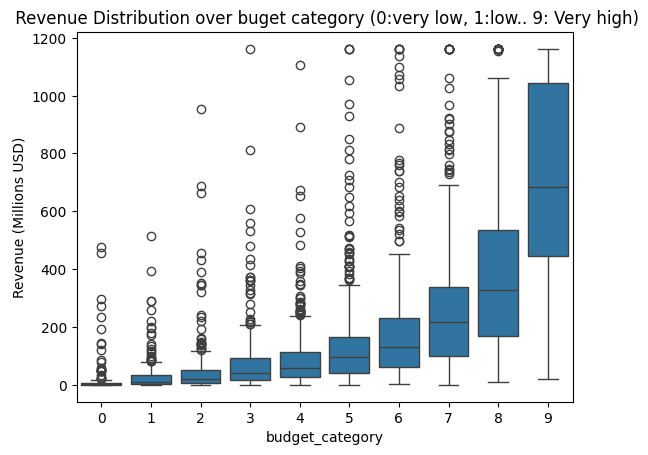

In [55]:
sns.boxplot(x='budget_category', y='revenue_corrected', data=movies)
plt.ylabel("Revenue (Millions USD)")
plt.title(f" Revenue Distribution over buget category (0:very low, 1:low.. 9: Very high)")
plt.show()

In [56]:
movies['budget_category'].unique()

array([9, 8, 3, 6, 7, 2, 5, 4, 1, 0])

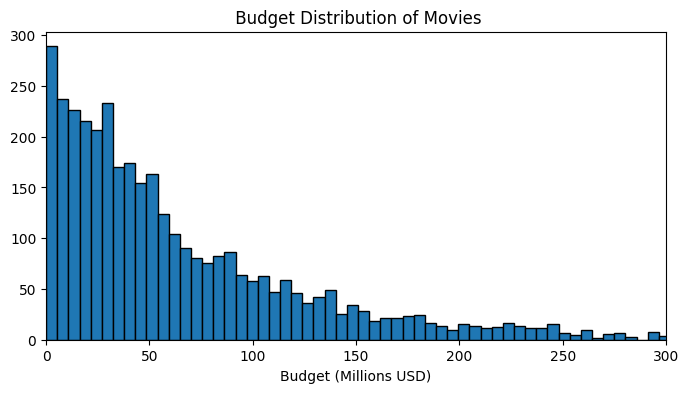

In [57]:
plt.figure(figsize=(8,4))
plt.hist(movies['budget_corrected'], bins=100, edgecolor='k')
plt.xlim(0,300)
plt.xlabel("Budget (Millions USD)")
plt.title(f" Budget Distribution of Movies")
plt.show()

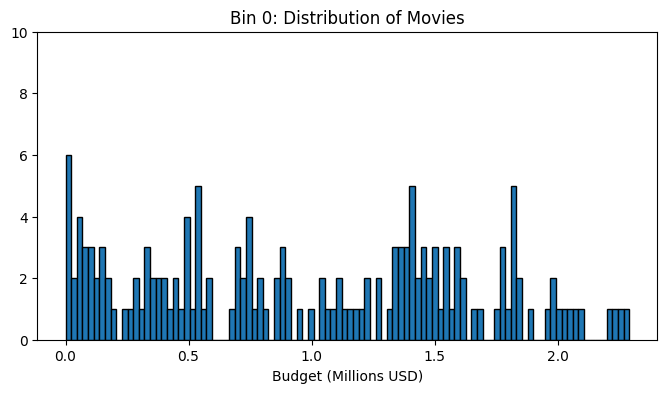

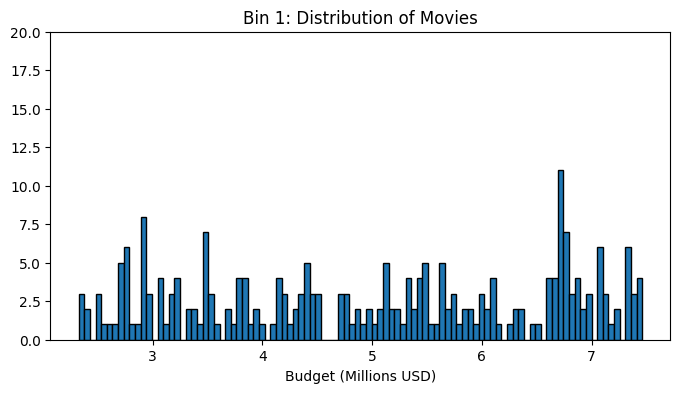

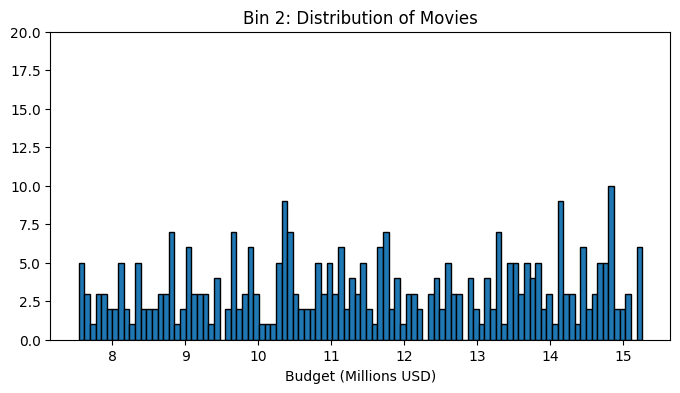

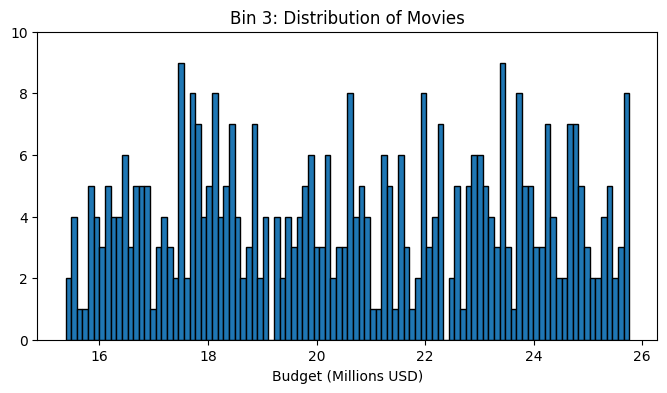

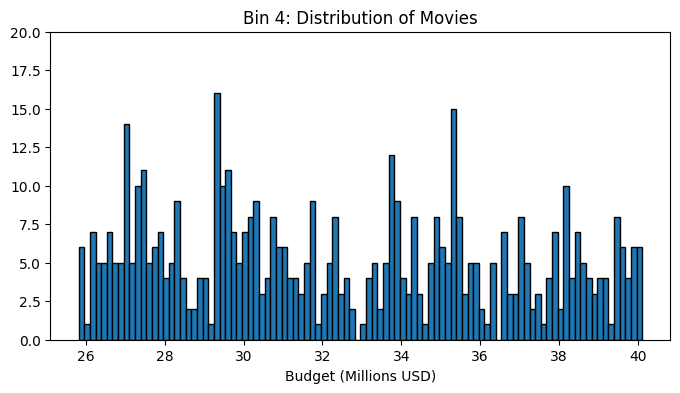

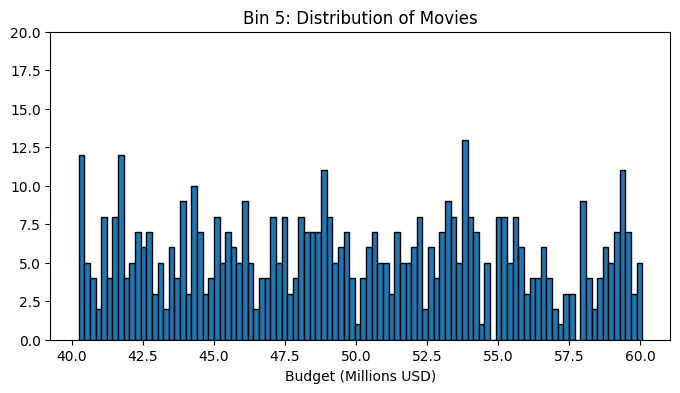

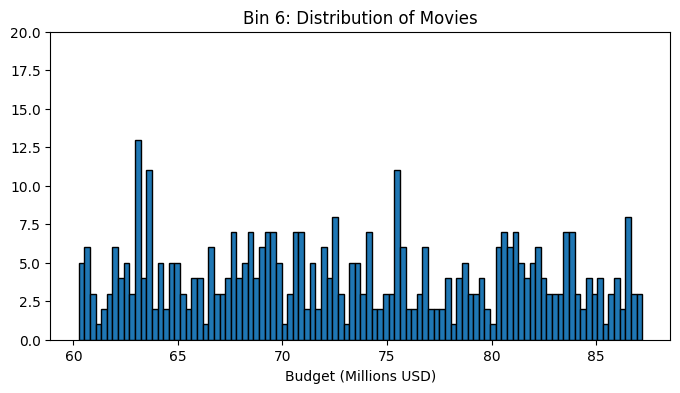

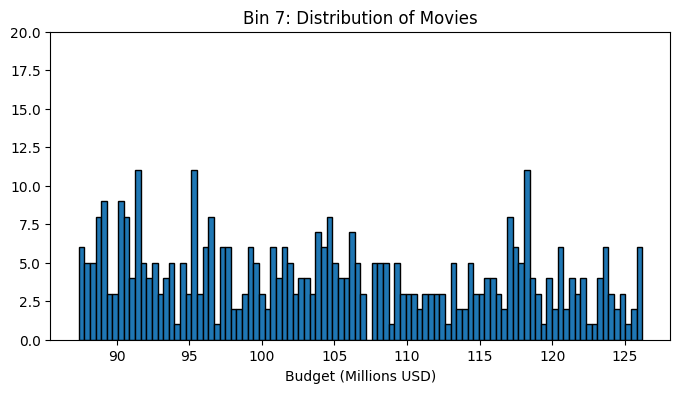

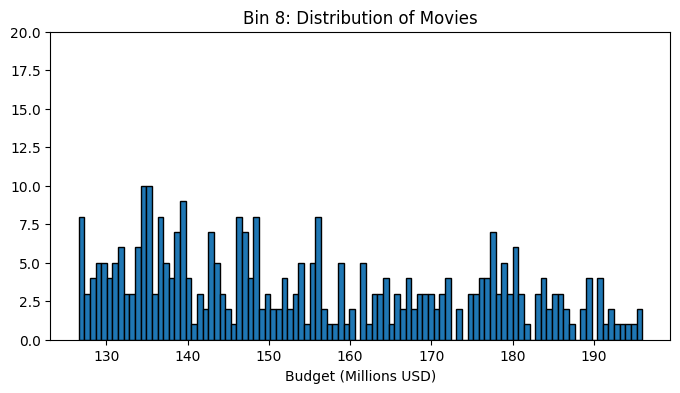

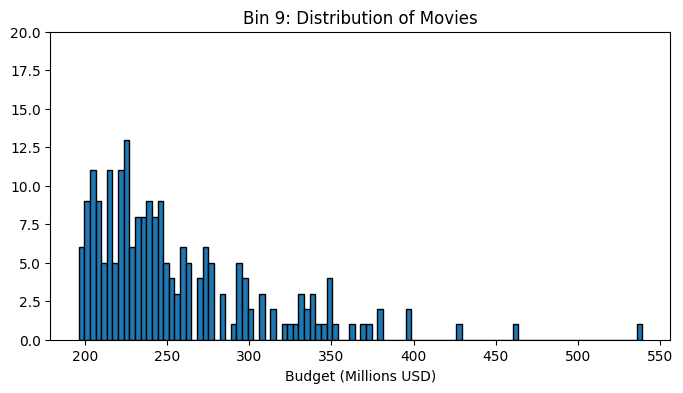

In [58]:
cat_scale = [10,20,20,10,20,20,20,20,20,20]
for cat in range(len(movies['budget_category'].unique())):
    plot_budget_category(movies, cat, cat_scale[cat])

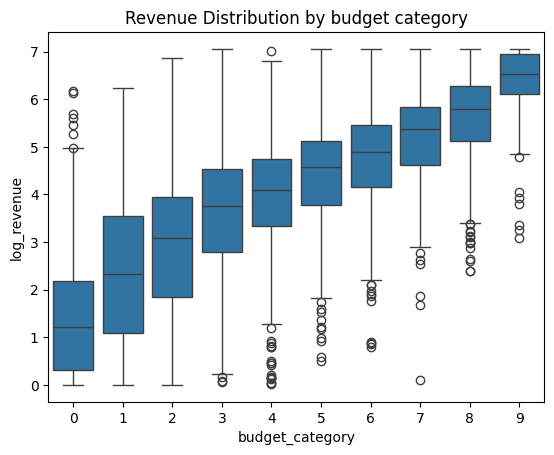

In [59]:
sns.boxplot(
    x="budget_category",
    y="log_revenue",
    data=movies
)

plt.title("Revenue Distribution by budget category")
plt.show()


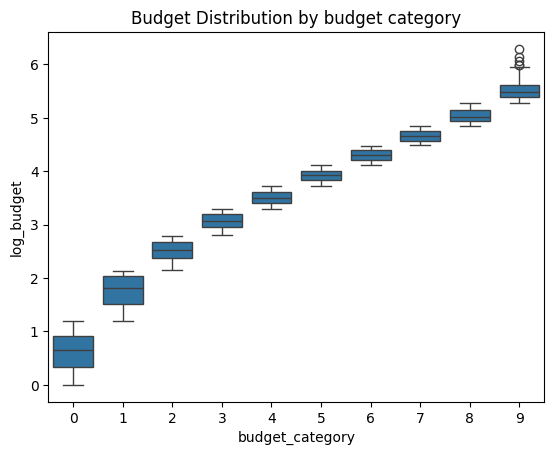

In [60]:
sns.boxplot(
    x="budget_category",
    y="log_budget",
    data=movies
)

plt.title("Budget Distribution by budget category")
plt.show()

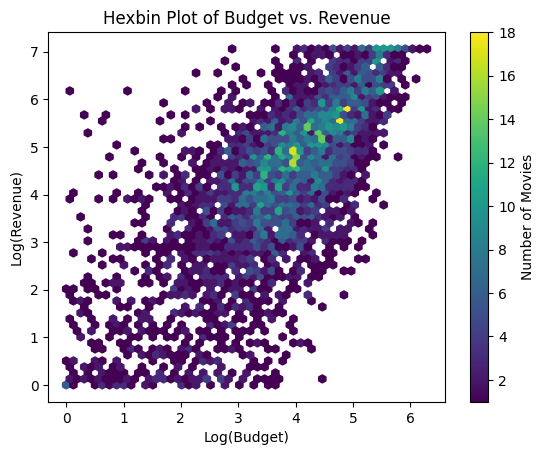

In [61]:
plt.hexbin(movies["log_budget"], movies["log_revenue"],
    gridsize=50,
    cmap='viridis',
    mincnt=1
)
plt.colorbar(label='Number of Movies')
plt.xlabel("Log(Budget)")
plt.ylabel("Log(Revenue)")
plt.title("Hexbin Plot of Budget vs. Revenue")
plt.show()


### Budget Classifier

Model to classify budget bin based on the kmean clusters.


In [62]:
# Input feature
features = ["budget_corrected"]

In [63]:
len(movies["budget_category"].unique())

10

In [64]:
X_class = movies[features]

# Specify target as budget cluster
y_class = movies["budget_category"]

# Train/test split
X_class_train_clf, X_class_test_clf, y_class_train_clf, y_class_test_clf = train_test_split(
    X_class, y_class, test_size=0.2, random_state=42
)

# Create XGB classifier 
clf = XGBClassifier(
    n_estimators=300,
    max_depth=4,
    learning_rate=0.1,    
    random_state=42,
    use_label_encoder=False,
    eval_metric="logloss"
)

# Train
clf.fit(X_class_train_clf, y_class_train_clf)

# Evaluate
y_class_pred_clf= clf.predict(X_class_test_clf)
print(classification_report(y_class_test_clf, y_class_pred_clf))

C:\Users\bplse\anaconda3\envs\Tf_210_Py_3819_Cuda_112_Cudn_81\lib\site-packages\xgboost\core.py:158: UserWarning: [16:45:06] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


              precision    recall  f1-score   support

           0       0.95      1.00      0.97        36
           1       1.00      0.96      0.98        48
           2       1.00      0.98      0.99        51
           3       0.99      0.99      0.99        81
           4       0.99      0.99      0.99        97
           5       0.99      0.99      0.99       104
           6       0.99      1.00      0.99        94
           7       0.99      1.00      0.99        83
           8       1.00      0.99      0.99        77
           9       1.00      1.00      1.00        53

    accuracy                           0.99       724
   macro avg       0.99      0.99      0.99       724
weighted avg       0.99      0.99      0.99       724



In [65]:
# Save model when needed
if save:
    clf.save_model('../model/budget_bin_model.json')
    clf.save_model('../model/budget_bin_model.bin')

C:\Users\bplse\anaconda3\envs\Tf_210_Py_3819_Cuda_112_Cudn_81\lib\site-packages\xgboost\core.py:158: UserWarning: [16:45:11] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\c_api\c_api.cc:1374: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose between formats.
  warnings.warn(smsg, UserWarning)


## 3. Revenue Prediction Model

In [66]:
# Calculate regression baseline errors
def calculate_baseline_errors(y_train, y_test, criteria='mean'):   
    print("Baseline criteria :", criteria)
    if criteria == 'mean':
        revenue_value = np.mean(y_train)
    elif criteria == 'median':
        revenue_value = np.median(y_train)   

    # assign baseline as revenue_value for y_test
    y_pred = np.full(shape=len(y_test), fill_value=revenue_value)

    # Calculate metrics
    mae = mean_absolute_error(y_test, y_pred)
    medae = median_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    print(f"\tRevenue: {revenue_value:.2f}")
    print(f"\tMAE: {mae:.2f}")
    print(f"\tMEDAE: {medae:.2f}")
    print(f"\tR²: {r2:.3f}")

    metrics = {
        'revenue_value': revenue_value,
        'mae': mae,
        'medae': medae,
        'r2': r2
    }

    return metrics


In [67]:
class RevenueRegressor:
    def __init__(self, xgb_params=None):       
        
        self.xgb_params = xgb_params if xgb_params is not None else {  
            'objective':'reg:absoluteerror',
            'n_estimators': 300,
            'max_depth': 6,
            'learning_rate': 0.1,
            'random_state': 42,
            'eval_metric':'mae',
            'early_stopping_rounds':10
        }
        self.model = XGBRegressor(**self.xgb_params)
       

    def fit(self, X, y, X_val, y_val):
        # Fit model
        self.model.fit(X, y, eval_set=[(X_val, y_val)], verbose=False)

    def feature_importance(self):
        importances = self.model.feature_importances_
        print("Feature importance:", importances)


    def predict(self, X_test):        
        y_pred = self.model.predict(X_test)               
        return y_pred

    def evaluate(self, X_test, y_true):       
        y_pred = self.predict(X_test)        
        mae = mean_absolute_error(y_true, y_pred)
        medae = median_absolute_error(y_true, y_pred)
        r2 = r2_score(y_true, y_pred)
        
        print(f"Mean Absolute Error: {mae:.2f}")
        print(f"Median Absolute Error: {medae:.2f}")
        print(f"R2: {r2:.3f}")        
        return y_pred


    def hit_or_flop_df(self, budget_array, revenue_pred, revenue_true):     
        pred_status = np.where(revenue_pred > 2*budget_array, "HIT", "FLOP")
        actual_status = np.where(revenue_true > 2*budget_array, "HIT", "FLOP")
        result = np.where(pred_status == actual_status, "Same", "Mismatch")
        
        df = pd.DataFrame({
            "budget": budget_array,
            "revenue_pred": revenue_pred,
            "revenue_true": revenue_true,
            "pred_status": pred_status,
            "actual_status": actual_status,
            "comparison": result
        })
        
        return df



    def plot_residuals(self, y_true, y_pred):
       
        residuals = y_true - y_pred
        print("Mean residual:", residuals.mean())
        print("Std of residuals:", residuals.std())
        plt.figure(figsize=(8,5))
        plt.scatter(y_pred, residuals, alpha=0.5)
        plt.axhline(0, color='red', linestyle='--')
        plt.xlabel("Predicted Revenue ($)")
        plt.ylabel("Residuals ($)")
        plt.title("Residuals vs Predicted Revenue")
        plt.show()
        
    def plot_prediction(self, y_true, y_pred):       
        plt.figure(figsize=(8,5))
        plt.scatter(y_true, y_pred, alpha=0.5)
        plt.axhline(0, color='red', linestyle='--')
        plt.xlabel("Actual Revenue (million$)")
        plt.ylabel("Predicted Revenue (million$)")
        plt.title("Predicted vs Actual Revenue")
        plt.show()

        plt.figure(figsize=(8,5))
        plt.scatter(y_true, y_pred, alpha=0.5)
        plt.xlim(0,1000)
        plt.ylim(0,1000)
        plt.axhline(0, color='red', linestyle='--')
        plt.xlabel("Actual Revenue (million$)")
        plt.ylabel("Predicted Revenue (million $)")
        plt.title("Zoomed Predicted vs Actual Revenue")
        plt.show()

    def save_model(self):
        self.model.save_model("../model/revenue_prediction_xgb_model.json")
        self.model.save_model("../model/revenue_prediction_xgb_model.bin")



### Training

In [68]:
# Define features to train on
features = [
    'budget_corrected',
    'popularity',
    'runtime',
    'season_encoded',
    'budget_category',
    'main_genre_label',
    'vote_count',
    'vote_average'
]
# Define target variable
target_to_predict = 'revenue_corrected'
X = movies[features]
y = movies[target_to_predict]

# Train / temp split
X_train, X_temp, y_train, y_temp = train_test_split( X, y, test_size=0.4, random_state=42)

# val / test split
X_val, X_test, y_val, y_test = train_test_split( X_temp, y_temp, test_size=0.5, random_state=42)

print("Train size:", len(X_train))
print("Test size:", len(X_test))
print("Val size:", len(X_val))

# Initialize regressor object 
regressor_xg = RevenueRegressor()
# Train model
regressor_xg.fit(X_train, y_train, X_val, y_val)

# Check feature importance
regressor_xg.feature_importance()        

Train size: 2170
Test size: 724
Val size: 723
Feature importance: [0.14261943 0.05888492 0.05713774 0.06398297 0.27235565 0.0590023
 0.28624973 0.05976723]


#### Evaluate

In [69]:
# Regression Baseline
error_baseline_mean = calculate_baseline_errors(y_train, y_test, criteria='mean')
error_baseline_median = calculate_baseline_errors(y_train, y_test, criteria='median')

Baseline criteria : mean
	Revenue: 182.70
	MAE: 174.33
	MEDAE: 139.68
	R²: -0.002
Baseline criteria : median
	Revenue: 84.43
	MAE: 156.99
	MEDAE: 71.27
	R²: -0.179


Mean Absolute Error: 79.90
Median Absolute Error: 38.19
R2: 0.690


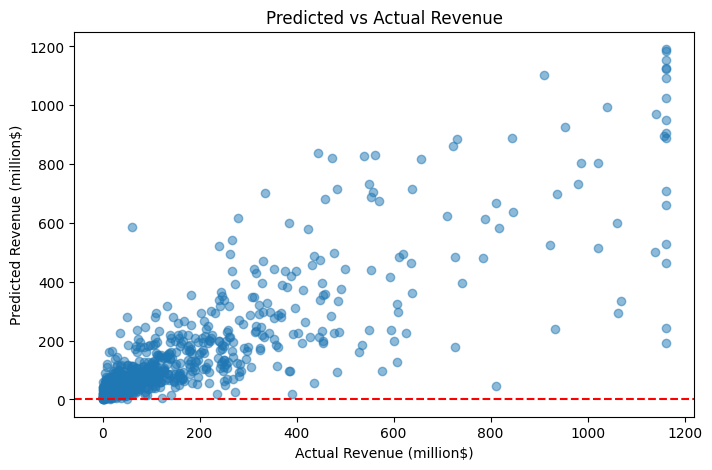

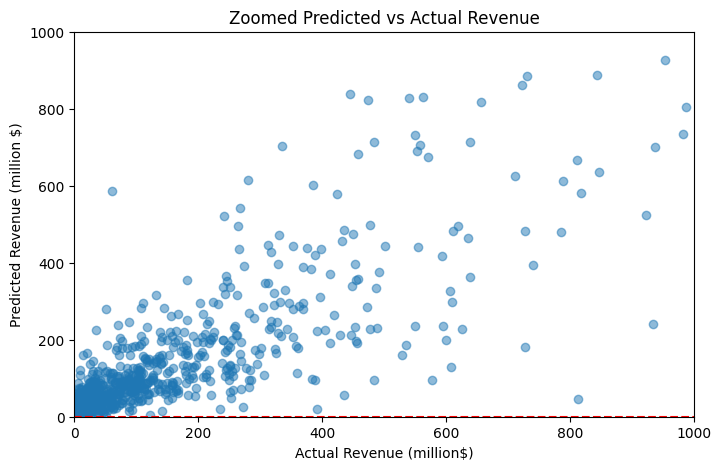

In [70]:
# XGBRegressor: Evaluate on test set
y_pred = regressor_xg.evaluate(X_test, y_test)

regressor_xg.plot_prediction(y_test, y_pred)

#### Save

In [71]:
# Save model when needed
if save:
    regressor_xg.save_model()

C:\Users\bplse\anaconda3\envs\Tf_210_Py_3819_Cuda_112_Cudn_81\lib\site-packages\xgboost\core.py:158: UserWarning: [16:45:13] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\c_api\c_api.cc:1374: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose between formats.
  warnings.warn(smsg, UserWarning)


## Classification Model (Hit or FLop)

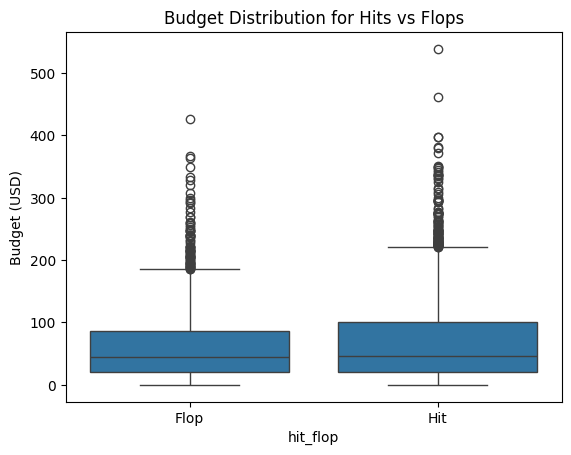

In [72]:
sns.boxplot(
    x="hit_flop",
    y="budget_corrected",
    data=movies
)

plt.xticks([0,1], ["Flop", "Hit"])
plt.ylabel("Budget (USD)")
plt.title("Budget Distribution for Hits vs Flops")
plt.show()

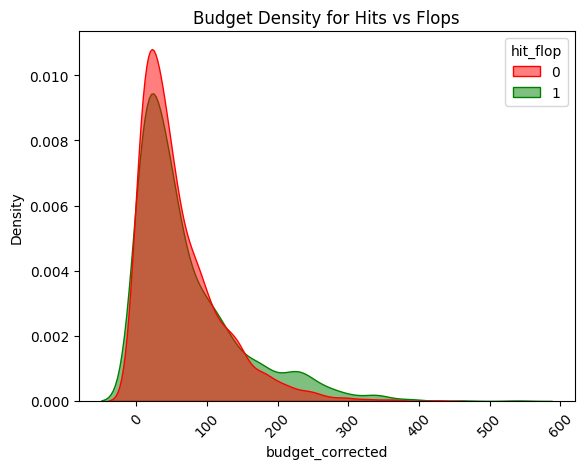

In [73]:
sns.kdeplot(
    data=movies,
    x="budget_corrected",
    hue="hit_flop",
    common_norm=False,
    fill=True,
    alpha=0.5,
    palette={0: "red", 1: "green"}
)

plt.xticks(rotation=45)
plt.title("Budget Density for Hits vs Flops")
plt.show()


In [74]:
hit_flop_df = regressor_xg.hit_or_flop_df(X_test["budget_corrected"], y_pred, y_test)

In [75]:
print(hit_flop_df['comparison'].value_counts())

Same        530
Mismatch    194
Name: comparison, dtype: int64


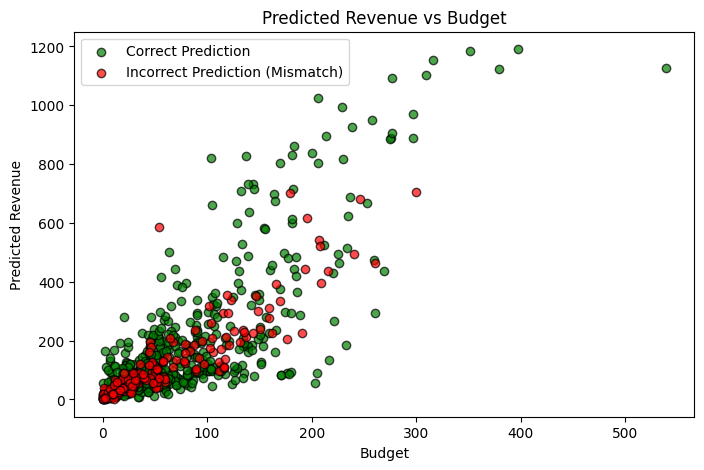

In [76]:
# Split data
same = hit_flop_df[hit_flop_df["comparison"] == "Same"]
mismatch = hit_flop_df[hit_flop_df["comparison"] == "Mismatch"]

plt.figure(figsize=(8,5))

# Plot correct predictions (green)
plt.scatter(
    same["budget"],
    same["revenue_pred"],
    color="green",
    label="Correct Prediction",
    alpha=0.7,
    edgecolor='black'
)

# Plot mismatches (red)
plt.scatter(
    mismatch["budget"],
    mismatch["revenue_pred"],
    color="red",
    label="Incorrect Prediction (Mismatch)",
    alpha=0.7,
    edgecolor='black'
)

plt.xlabel("Budget")
plt.ylabel("Predicted Revenue")
plt.title("Predicted Revenue vs Budget")
plt.legend()
plt.show()



In [77]:
features_hit_flop = [
    "budget_corrected",
    'popularity',
    'runtime',
    'season_encoded',
    'budget_category',
    'main_genre_label',
    'vote_count',   
]

# Define target variable
target_to_classify = 'hit_flop'
X_fit_flop_class = movies[features_hit_flop]

# Specify target as budget cluster
y_class = movies[target_to_classify]



# Train / temp split
X_class_train_clf, X_temp, y_class_train_clf, y_temp = train_test_split(
    X_fit_flop_class, y_class,
    test_size=0.4,
    random_state=42,
    stratify=y_class
)

# val / test split
X_class_val_clf, X_class_test_clf, y_class_val_clf, y_class_test_clf = train_test_split(
    X_temp, y_temp,
    test_size=0.5,
    random_state=42,
    stratify=y_temp
)




In [78]:
# Classification baseline using dummy classifier 
from sklearn.dummy import DummyClassifier
positive_label  =1

# stratified: random guessing based on class frequencies
dummy = DummyClassifier(strategy='stratified', random_state=42)
dummy.fit(X_class_train_clf, y_class_train_clf)

y_pred_baseline = dummy.predict(X_class_test_clf)

 # Compute metrics
accuracy = accuracy_score(y_class_test_clf, y_pred_baseline)
precision = precision_score(y_class_test_clf, y_pred_baseline, pos_label=positive_label, zero_division=0)
recall = recall_score(y_class_test_clf, y_pred_baseline, pos_label=positive_label, zero_division=0)
f1 = f1_score(y_class_test_clf, y_pred_baseline, pos_label=positive_label, zero_division=0)


print(f"Accuracy: {accuracy:.3f}")
print(f"Precision: {precision:.3f}")
print(f"Recall: {recall:.3f}")
print(f"F1-score: {f1:.3f}")

print(classification_report(y_class_test_clf, y_pred_baseline))

Accuracy: 0.486
Precision: 0.489
Recall: 0.489
F1-score: 0.489
              precision    recall  f1-score   support

           0       0.48      0.48      0.48       360
           1       0.49      0.49      0.49       364

    accuracy                           0.49       724
   macro avg       0.49      0.49      0.49       724
weighted avg       0.49      0.49      0.49       724



In [79]:
# Create XGB classifier 
hf_clf = XGBClassifier(
    n_estimators=300,
    max_depth=7,
    learning_rate=0.1,    
    random_state=42,
    use_label_encoder=False,
    eval_metric="logloss",
    early_stopping_rounds=10
)

# Train
hf_clf.fit(X_class_train_clf, y_class_train_clf, eval_set=[(X_class_val_clf, y_class_val_clf)], verbose=False)

# Evaluate
y_class_pred_clf= hf_clf.predict(X_class_test_clf)
print("Test accuracy:", accuracy_score(y_class_test_clf, y_class_pred_clf))
print(classification_report(y_class_test_clf, y_class_pred_clf))

C:\Users\bplse\anaconda3\envs\Tf_210_Py_3819_Cuda_112_Cudn_81\lib\site-packages\xgboost\core.py:158: UserWarning: [16:45:15] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Test accuracy: 0.7279005524861878
              precision    recall  f1-score   support

           0       0.70      0.80      0.75       360
           1       0.77      0.65      0.71       364

    accuracy                           0.73       724
   macro avg       0.73      0.73      0.73       724
weighted avg       0.73      0.73      0.73       724



In [80]:
# Save model when needed
if save:
    hf_clf.save_model('../model/hit_flop_classifier.json')
    hf_clf.save_model('../model/hit_flop_classifier.bin')

C:\Users\bplse\anaconda3\envs\Tf_210_Py_3819_Cuda_112_Cudn_81\lib\site-packages\xgboost\core.py:158: UserWarning: [16:45:15] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\c_api\c_api.cc:1374: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose between formats.
  warnings.warn(smsg, UserWarning)


# Test case for Interface : Movie Revenue Prediction

##### season_encoded :
Summer_Season :  month in [5, 6, 7]

Holiday_Season : month in [11, 12]

Off_Season : month in [1, 2, 9]

Regular : month in [3, 4, 8, 10]

In [81]:
# Generate a sample from movies data
sample_i =0 
print("Movie:", movies.iloc[sample_i]['title'])
# budget catagory
b_value = np.array([movies.iloc[sample_i]['budget_corrected']])
budget_class_pred= clf.predict(b_value)

movie_sample = {
    'budget_corrected': movies.iloc[sample_i]['budget_corrected'],
    'popularity': movies.iloc[sample_i]['popularity'],
    'runtime': movies.iloc[sample_i]['runtime'],
    'season_encoded': movies.iloc[sample_i]['season_encoded'],
    'budget_category': budget_class_pred[0],
    'main_genre_label': movies.iloc[sample_i]['main_genre_label'],
    'vote_count': movies.iloc[sample_i]['vote_count'],
    'vote_average': movies.iloc[sample_i]['vote_average']
}

# Get the values in the right order:
feature_order = [
    'budget_corrected',
    'popularity',
    'runtime',
    'season_encoded',
    'budget_category',
    'main_genre_label',
    'vote_count',
    'vote_average',
]

# Extract values
values = [movie_sample[feature] for feature in feature_order]

# Convert to numpy array
sample_to_test = np.array([values])

# Target variable (revenue)
movie_revenue_sample_to_test = movies.iloc[sample_i]['revenue_corrected']


print(movie_sample)
print(movie_revenue_sample_to_test)


Movie: Avatar
{'budget_corrected': 351.83057110706693, 'popularity': 150.437577, 'runtime': 162.0, 'season_encoded': 0, 'budget_category': 9, 'main_genre_label': 0, 'vote_count': 11800, 'vote_average': 7}
1162.0999723262516


In [82]:
pred = regressor_xg.predict(sample_to_test)  
print("Predicted revenue (million $):",pred[0], "\nActual revenue (million $):", movie_revenue_sample_to_test)
print("Prediction Error((million $)): ", abs(pred[0]-movie_revenue_sample_to_test))
#regressor_xg.plot_prediction(movie_revenue_sample, pred)

Predicted revenue (million $): 1184.8239 
Actual revenue (million $): 1162.0999723262516
Prediction Error((million $)):  22.723880212810855


In [83]:
###########################################

## Test case for Interface : Movie Classification (Hit/Flop)

In [84]:
movies.columns

Index(['budget', 'original_language', 'popularity', 'release_date', 'revenue',
       'runtime', 'status', 'vote_average', 'vote_count', 'title',
       'release_year', 'release_month', 'genre_labels', 'cpi_date', 'CPI',
       'cpi_multiplier', 'budget_corrected', 'revenue_corrected', 'hit_flop',
       'log_budget', 'log_revenue', 'budget_category', 'budget_bin_label',
       'title_len', 'main_genre', 'main_genre_label', 'movie_season',
       'season_encoded'],
      dtype='object')

In [85]:
# Generate a sample from movies data
sample_i =1 
print("Movie:", movies.iloc[sample_i]['title'])
# budget catagory
b_value = np.array([movies.iloc[sample_i]['budget_corrected']])
budget_class_pred= clf.predict(b_value)

movie_sample = {
    'budget_corrected': movies.iloc[sample_i]['budget_corrected'],
    'popularity': movies.iloc[sample_i]['popularity'],
    'runtime': movies.iloc[sample_i]['runtime'],
    'season_encoded': movies.iloc[sample_i]['season_encoded'],
    'budget_category': budget_class_pred[0],
    'main_genre_label': movies.iloc[sample_i]['main_genre_label'],
    'vote_count': movies.iloc[sample_i]['vote_count']
}

# Get the values in the right order:
feature_order = [
    'budget_corrected',
    'popularity',
    'runtime',
    'season_encoded',
    'budget_category',
    'main_genre_label',
    'vote_count',
]

# Extract values
values = [movie_sample[feature] for feature in feature_order]

# Convert to numpy array
sample_to_test = np.array([values])

# Target variable (class)
movie_target_feature = movies.iloc[sample_i]['hit_flop']


print(movie_sample)
print(movie_target_feature)


Movie: Pirates of the Caribbean: At World's End
{'budget_corrected': 462.488398597733, 'popularity': 139.082615, 'runtime': 169.0, 'season_encoded': 3, 'budget_category': 9, 'main_genre_label': 1, 'vote_count': 4500}
1


In [86]:
# predict success class (1-hit, 0-flop)
y_class_pred= hf_clf.predict(sample_to_test)

print("Actual Class : ", movie_target_feature)
print("Predicted Class : ", y_class_pred[0])

Actual Class :  1
Predicted Class :  1
